## Subquestion 3 pipeline
TO SOLVE: Are there noticeable patterns of sentiment oscillation in the paths chosen by players? For instance, do players often navigate through contrasting sentiments to reach their target, such as starting from an article with a negative tone like “Hell” to reach a positive one like “Paradise”?

### Loading data
loading the paths and sentiment scores for each article
Assumptions:
- graph is undirected, because the user can always return back to the previous article via the back button.
- User paths can have circle, the back button in path is equivalent as the previous previous article.
- The sentiment score is generated by Roberta model and it's a 3 dimensional(positive neutral negative) vector, the sum of the 3 dimensions is 1.

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def replace_lt_with_previous(article_path):
    path_elements = article_path.split(';')
    for i, element in enumerate(path_elements):
        if element == '<' and i > 1:
            path_elements[i] = path_elements[i-2]
    return ';'.join(path_elements)

In [3]:
file_path = '../data/paths_finished.tsv'
df_finished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
df_finished.columns = cols
df_finished['target'] = df_finished['path'].apply(lambda x: x.split(';')[-1])
df_finished['type'] = 'finished'
file_path = '../data/paths_unfinished.tsv'
df_unfinished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
df_unfinished.columns = cols
df = pd.concat([df_finished, df_unfinished], axis=0)
df['start'] = df['path'].apply(lambda x: x.split(';')[0])
df['path_length'] = df['path'].apply(lambda x: len(x.split(';')))
df['path'] = df['path'].apply(replace_lt_with_previous)
# dump to csv
df[['durationInSec', 'path', 'target', 'type', 'start', 'path_length']].to_csv('../data/paths.tsv', sep='\t', index=False)

In [4]:
articles = pd.read_csv('../data/articles.tsv', sep='\t', header=None)
file_path = '../data/links.tsv'
df_links = pd.read_csv(file_path, sep='\t', header=None)
articles.columns = ['article']
degree_out = df_links.groupby(0).count().reset_index()
degree_out.columns = ['article', 'degree_out']
degree_in = df_links.groupby(1).count().reset_index()
degree_in.columns = ['article', 'degree_in']
articles = articles.merge(degree_out, on='article', how='left').fillna(0).merge(degree_in, on='article', how='left').fillna(0)
articles['degree'] = articles['degree_out'] + articles['degree_in']
article_freq = pd.DataFrame(df['path'].apply(lambda x: x.split(';')).explode().value_counts()).reset_index()
articles_cnt = pd.merge( articles, article_freq, left_on='article', right_on='path', how='left').fillna(0)
articles_cnt.head()

,article,degree_out,degree_in,degree,path,count
0,# The list of all articles.,0.0,0.0,0.0,0,0.0
1,"# Article names are URL-encoded; e.g., in Java...",0.0,0.0,0.0,0,0.0
2,# FORMAT: article,0.0,0.0,0.0,0,0.0
3,#,0.0,0.0,0.0,0,0.0
4,"# When publishing on this data set, please cite:",0.0,0.0,0.0,0,0.0


In [5]:
with open('tmp/sentiments.pickle', 'rb') as handle:
    sentiments = pickle.load(handle)

articles_cnt['sentiment_pos'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][2] if x+".txt" in sentiments else 0)
articles_cnt['sentiment_neu'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][1] if x+".txt" in sentiments else 0)
articles_cnt['sentiment_neg'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][0] if x+".txt" in sentiments else 0)
articles_cnt[['article','degree','sentiment_pos', 'sentiment_neu', 'sentiment_neg']].to_csv('../data/articles_sentiments.tsv', sep='\t', index=False)
articles_cnt
# output the df to csv
# articles_cnt.to_csv('../data/articles.tsv', sep='\t', index=False)

,article,degree_out,degree_in,degree,path,count,sentiment_pos,sentiment_neu,sentiment_neg
0,# The list of all articles.,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
1,"# Article names are URL-encoded; e.g., in Java...",0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
2,# FORMAT: article,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
3,#,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
4,"# When publishing on this data set, please cite:",0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
4610,Zionism,74.0,25.0,99.0,Zionism,28.0,0.072466,0.663531,0.264004
4611,Zirconium,42.0,15.0,57.0,Zirconium,34.0,0.097269,0.781787,0.120944
4612,Zoroaster,28.0,9.0,37.0,Zoroaster,22.0,0.084953,0.786462,0.128585
4613,Zuid-Gelders,5.0,5.0,10.0,Zuid-Gelders,10.0,0.069110,0.797628,0.133262


### Sentiment visualization
It gives visualizations of the sentiment scores of the articles in the graph. and conduct some first glance observations.

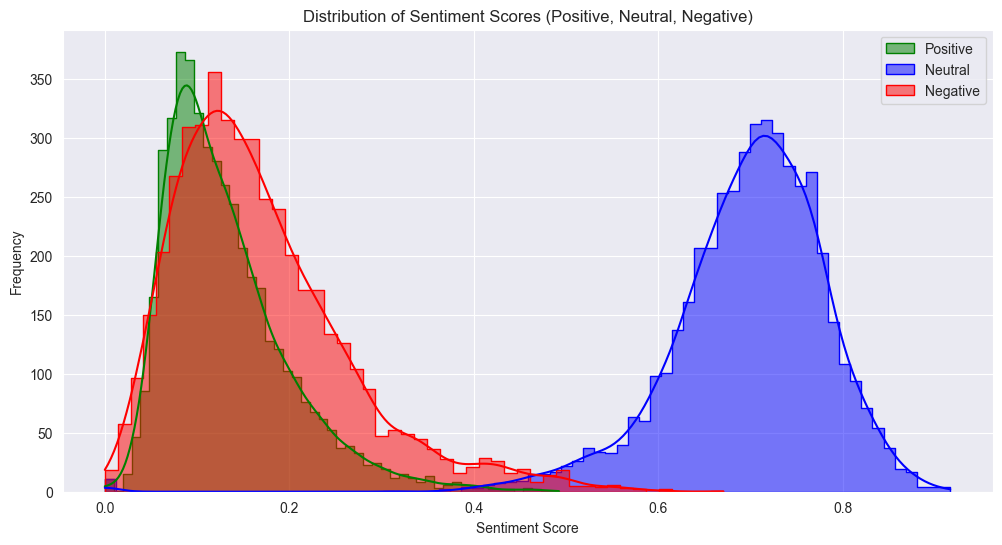

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(data=articles_cnt, x="sentiment_pos", color="green", label="Positive", kde=True, element="step")
sns.histplot(data=articles_cnt, x="sentiment_neu", color="blue", label="Neutral", kde=True, element="step")
sns.histplot(data=articles_cnt, x="sentiment_neg", color="red", label="Negative", kde=True, element="step")
plt.title("Distribution of Sentiment Scores (Positive, Neutral, Negative)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Firstly visualize the 3 type score saparately, we can see that the majority of the scores tend to be neutral, with fewer instances of strong positive or negative sentiments.

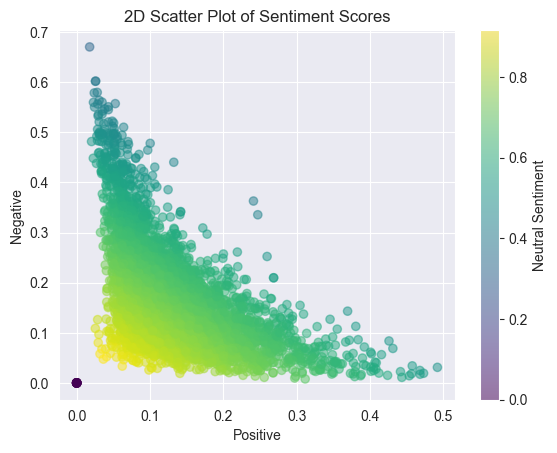

neutral article percentage: 


,article,degree_out,degree_in,degree,path,count,sentiment_pos,sentiment_neu,sentiment_neg
2158,Iraq_War,57.0,22.0,79.0,Iraq_War,77.0,0.024308,0.425385,0.550307


In [7]:
plt.scatter(articles_cnt['sentiment_pos'], articles_cnt['sentiment_neg'], c=articles_cnt['sentiment_neu'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Neutral Sentiment')
plt.title("2D Scatter Plot of Sentiment Scores")
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.grid(True)
plt.show()
print("neutral article percentage: ")
articles_cnt[(articles_cnt['sentiment_pos'] < 0.3) & (articles_cnt['sentiment_neg'] < 0.3)].shape[0] / articles_cnt.shape[0]
articles_cnt[articles_cnt['article'] == 'Iraq_War']

then we draw the distribution per article, neutral sentiment is article still the majority.(>88%)

### Edge Oscillation analysis
This block will analyze the sentiment oscillation pattern for edges in the network, it will be used to define the threshold of "oscillation" for the edges.
- sum of the absolute difference of the positive/negative sentiment scores between two articles in the edge is used to define the oscillation.
- the threshold is defined as the 90% quantile of the oscillation score.

In [8]:
link_sentiments = df_links.merge(articles_cnt[['article', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']], left_on=0, right_on='article', how='left').drop(columns=['article']).merge(articles_cnt[['article', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']], left_on=1, right_on='article', how='left',suffixes=('_0', '_1')).drop(columns=['article'])
link_sentiments["oscillation"] = abs(link_sentiments['sentiment_pos_0'] - link_sentiments['sentiment_pos_1']) + abs(link_sentiments['sentiment_neg_0'] - link_sentiments['sentiment_neg_1'])

threshold_oscillation = link_sentiments['oscillation'].quantile(0.9)
print("threshold of oscillation: ", threshold_oscillation)
# save the link_sentiments to csv
# link_sentiments.to_csv('../data/link_sentiments.tsv', sep='\t', index=False)

threshold of oscillation:  0.2802105601443185


we get the threshold of oscillation as **0.28**, random select 10 links with oscillation score higher than the threshold, and 10 links lower to see if the threshold is reasonable.

In [9]:
link_sentiments[link_sentiments['oscillation'] > 0.28].sample(10)

,0,1,sentiment_pos_0,sentiment_neu_0,sentiment_neg_0,sentiment_pos_1,sentiment_neu_1,sentiment_neg_1,oscillation
53226,Hurricane_Ivan,Atlantis,0.049873,0.521708,0.428419,0.089200,0.754380,0.156419,0.311327
34883,El_Salvador,Music_of_Spain,0.121037,0.597170,0.281793,0.250654,0.725191,0.024155,0.387254
115259,War,Anthropology,0.049537,0.518582,0.431880,0.102440,0.723685,0.173875,0.310907
38343,Fair_Isle,Shetland,0.401200,0.567084,0.031716,0.099732,0.808973,0.091295,0.361047
75694,Multiple_sclerosis,Canada,0.072813,0.520251,0.406936,0.208978,0.699237,0.091784,0.451318
13177,Battle_of_Alesia,Egypt,0.054259,0.599624,0.346117,0.151306,0.693953,0.154741,0.288423
52919,Humphry_Davy,Iodine,0.164724,0.763876,0.071399,0.058243,0.637897,0.303860,0.338943
86921,Polish%E2%80%93Muscovite_War_%281605%E2%80%931...,Opera,0.058507,0.651742,0.289751,0.214400,0.733925,0.051676,0.393969
78313,New_York_City,September_11%2C_2001_attacks,0.266598,0.656196,0.077206,0.034736,0.468619,0.496645,0.651302
108388,Tiktaalik,Crocodile,0.249895,0.719472,0.030633,0.113629,0.689188,0.197183,0.302817


In [10]:
link_sentiments[link_sentiments['oscillation'] < 0.28].sample(10)

,0,1,sentiment_pos_0,sentiment_neu_0,sentiment_neg_0,sentiment_pos_1,sentiment_neu_1,sentiment_neg_1,oscillation
96872,Seaborgium,Bohrium,0.077101,0.845352,0.077546,0.060259,0.852763,0.086978,0.026274
99340,Smallpox,Roman_Empire,0.048696,0.523968,0.427336,0.065348,0.678970,0.255682,0.188307
119517,Zheng_He,Guangzhou,0.060579,0.775019,0.164402,0.117587,0.825559,0.056854,0.164556
92913,Roman_Empire,Africa,0.065348,0.678970,0.255682,0.091729,0.717100,0.191172,0.090891
96979,Seattle%2C_Washington,Mount_Rainier,0.244570,0.672309,0.083120,0.180217,0.716485,0.103298,0.084532
13251,Battle_of_Britain,Nazi_Germany,0.063146,0.501565,0.435289,0.059837,0.617856,0.322308,0.116290
41695,Funchal,Atlantic_Ocean,0.164147,0.791195,0.044659,0.102551,0.733198,0.164251,0.181187
84672,Persian_Empire,Royal_Navy,0.058836,0.780697,0.160466,0.100179,0.718883,0.180938,0.061814
63452,Lesotho,European_Union,0.077545,0.692120,0.230335,0.106352,0.740249,0.153400,0.105741
66258,List_of_rivers_by_length,Volga_River,0.041066,0.776305,0.182629,0.080152,0.849134,0.070714,0.151000


Following is the analysis of 2 main concerns:
1. does the user tend to make a move that has obvious sentiment change?
2. does the user tend to cause more/less oscillation compared to the network average level?

In [11]:
link_sentiments['link'] = df_links[0] + ';' + df_links[1]
path_index = []
links = []
for index, row in df.iterrows():
    path = row['path'].split(';')
    for i in range(len(path)-1):
        link = path[i] + ';' + path[i+1]
        path_index.append(index)
        links.append(link)

In [12]:
path_link = pd.DataFrame({'path_index': path_index, 'link': links})
path_link_sentiment = path_link.merge(link_sentiments, on='link', how='left')

Draw the distribution of the oscillation score of all links, and the threshold of oscillation. we can see the user tends to choose close sentiments between words.

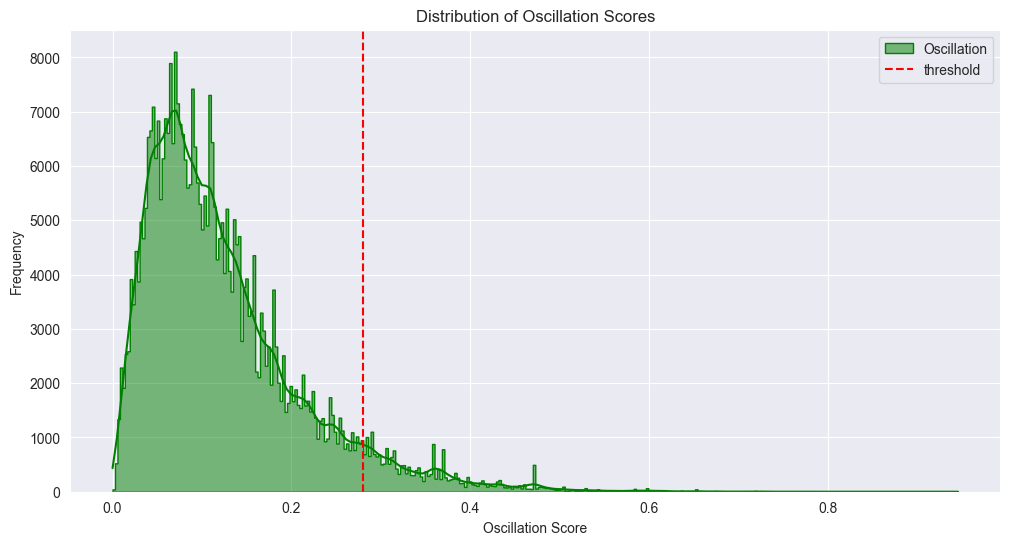

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(data=path_link_sentiment, x="oscillation", color="green", label="Oscillation", kde=True, element="step")
plt.axvline(x=threshold_oscillation, color='red', linestyle='--', label='threshold')
plt.title("Distribution of Oscillation Scores")
plt.xlabel("Oscillation Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

check which percentage of the links are above the threshold

In [14]:
path_link_sentiment[path_link_sentiment['oscillation'] > threshold_oscillation].shape[0] / path_link_sentiment.shape[0]

0.062066119835950784

Users choose %94 of the links as oscillation links, while oscillation links only account for %90 if random choose.
perfrom a random test to see if the threshold is reasonable.

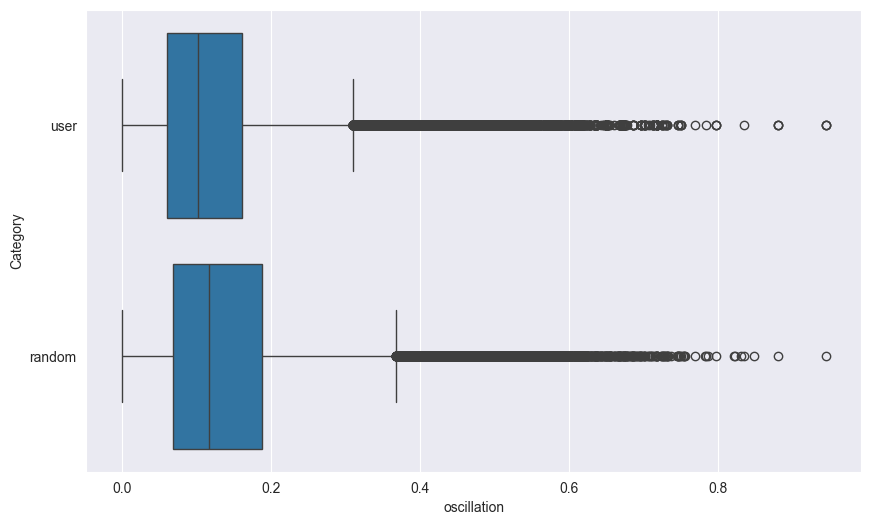

In [15]:

d1 = path_link_sentiment['oscillation']
d2 = link_sentiments['oscillation']

df_box = pd.concat([d1.rename('oscillation'), d2.rename('oscillation')], axis=0, keys=['user', 'random'], names=['Category']).reset_index()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, x='oscillation', y='Category')
plt.show()

In [16]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(link_sentiments['oscillation'],path_link_sentiment['oscillation'].dropna(), equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 55.93270338503617
p-value: 0.0


users dont tend to choose a more/less oscillated path

### Path oscillation analysis
This block will try to find factors that are correlated with the oscillation of a path, we mainly focus on the sentiment of start and end articles.

In [40]:
import pickle
# load pickled data
with open('./df_paths1.pickle', 'rb') as f:
    df = pickle.load(f)


In [77]:
def std_differenced_series(l):
    if(len(l) < 2):
        return 0
    return np.std(np.diff(l))


df['src'] = df['Scores'].apply(lambda x: x[0])
df['dst'] = df['Scores'].apply(lambda x: x[-1])
df['hp'] = df['Scores'].apply(lambda x: np.percentile(x, 25))
df['mp'] = df['Scores'].apply(lambda x: np.percentile(x, 50))
df['lp'] = df['Scores'].apply(lambda x: np.percentile(x, 75))
df.loc[df['Target score'].notna(), 'dst'] = df.loc[df['Target score'].notna(), 'Target score']
df['oscillation'] = df['Scores'].apply(lambda x: std_differenced_series(x))
df['diff'] = np.abs(df['dst'] - df['src'])
df['length'] = df['Scores'].apply(lambda x: len(x))
df['mean'] = df['Scores'].apply(lambda x: np.mean(x))
# output the df to csv
# df.to_csv('../data/paths_sentiment.csv', index=False)
df['oscillation'].describe()

count    76164.000000
mean         0.192886
std          0.188506
min          0.000000
25%          0.058579
50%          0.115168
75%          0.324489
max          1.303670
Name: oscillation, dtype: float64

we use standard deviation of a differenced sentiment list as the oscillation score of a path. the distribution is visualized below.

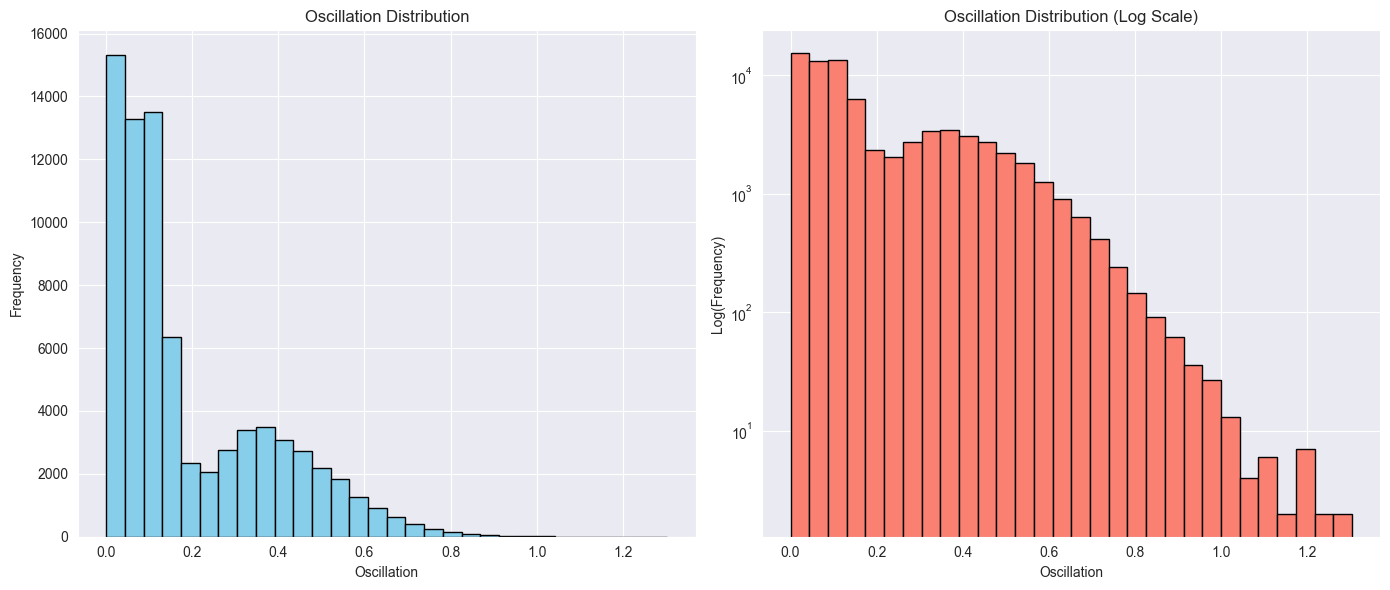

In [56]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.hist(df['oscillation'], bins=30, color='skyblue', edgecolor='black')
ax1.set_title('Oscillation Distribution')
ax1.set_xlabel('Oscillation')
ax1.set_ylabel('Frequency')
ax2.hist(df['oscillation'], bins=30, color='salmon', edgecolor='black', log=True)
ax2.set_title('Oscillation Distribution (Log Scale)')
ax2.set_xlabel('Oscillation')
ax2.set_ylabel('Log(Frequency)')
plt.tight_layout()
plt.show()

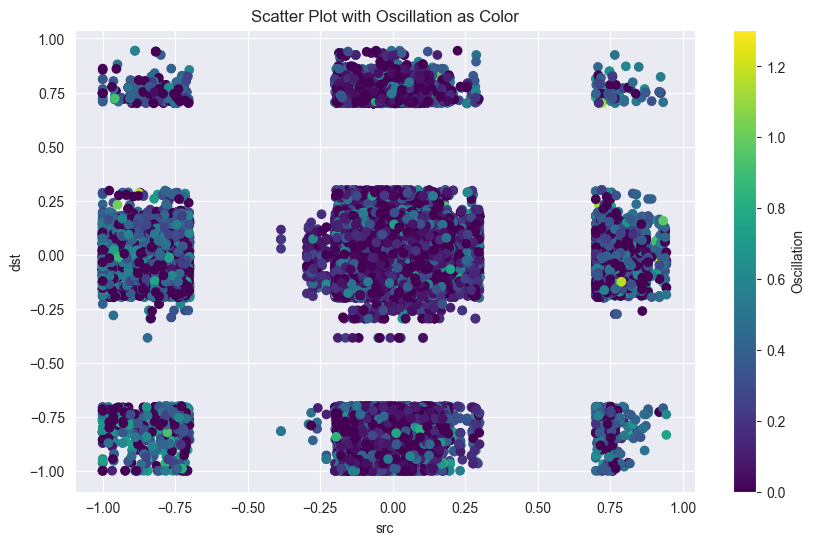

In [57]:
norm = plt.Normalize(df['oscillation'].min(), df['oscillation'].max())
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['src'], df['dst'], c=df['oscillation'], cmap='viridis', norm=norm)
plt.colorbar(scatter, label='Oscillation')
plt.xlabel('src')
plt.ylabel('dst')
plt.title('Scatter Plot with Oscillation as Color')
plt.grid(True)
plt.show()

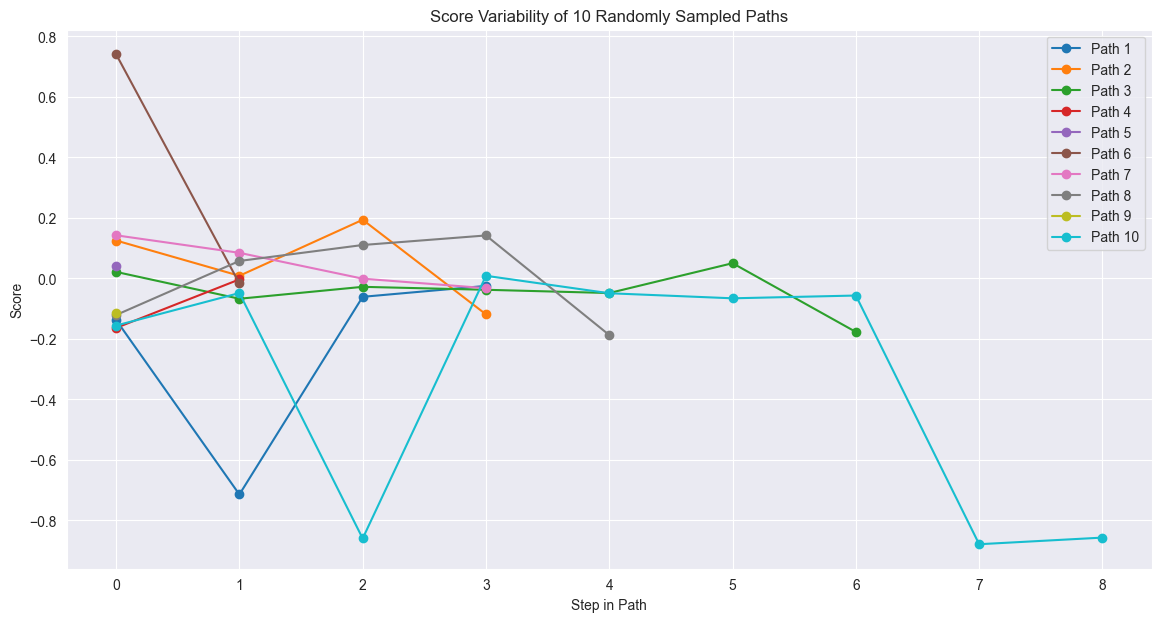

In [98]:
sampled_paths_10 = df['Scores'].sample(10)
plt.figure(figsize=(14, 7))
colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
for i, (scores, color) in enumerate(zip(sampled_paths_10, colors), start=1):
    plt.plot(scores, marker='o', label=f'Path {i}', color=color)

plt.title('Score Variability of 10 Randomly Sampled Paths')
plt.xlabel('Step in Path')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

It seems that the path will oscillate more when source and destination articles have more poralized sentiment, next we do regression analysis to see if this is true.

In [101]:

import statsmodels.formula.api as smf
from IPython.display import display, HTML
model = smf.ols(formula='oscillation ~ src + dst', data=df)
results = model.fit()
display(HTML(results.summary().as_html()))

# cross validation prediction


R is very small, which means the oscillation is not correlated with the sentiment of source and destination articles, we consider 25,50, 75 percentile of the path and keep fitting.

In [100]:
model2 = smf.ols(formula='oscillation ~ src + dst + hp + mp + lp', data=df)
results2 = model2.fit()
display(HTML(results2.summary().as_html()))

R is improved, then we consider some global attributes of the path(length/mean)

In [90]:
model3 = smf.ols(formula='oscillation ~ src + dst + hp + mp + lp + length + mean', data=df)
results3 = model3.fit()
display(HTML(results3.summary().as_html()))

R increased to a acceptable level, we can see that the explain power is low if we only consider source and target, we can predict the oscillation better only if we know more about the path itself.

In [107]:
correlation = df[['diff', 'oscillation']].corr().iloc[0, 1]
model4 = smf.ols(formula='oscillation ~ diff', data=df)
results4 = model4.fit()
print(f'Correlation between diff and oscillation: {correlation}')
# print only R squared value 
print(f'R squared value: {results4.rsquared}')

Correlation between diff and oscillation: 0.3224476643450003
R squared value: 0.10397249624154759


but the sentiment difference of source and target is correlated with the oscillation of the path, higher difference can lead to (%10 percentage)higher oscillation